In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from IPython.display import clear_output

from Alpha import Alpha

idx = pd.IndexSlice

In [44]:
# EMPTY TICKERS OR TICKERS WITH GAP

TICKERS_WITH_GAP = ['AAVEDOWN-USDT', 'BNBDOWN-USDT', 'DOTDOWN-USDT', 'DREP-USDT',
       'ETHDOWN-USDT', 'LINKDOWN-USDT', 'LTCDOWN-USDT', 'LUNA-USDT',
       'SUSHIDOWN-USDT', 'SXPDOWN-USDT', 'TRXDOWN-USDT', 'UNIDOWN-USDT',
       'XLMDOWN-USDT', 'XTZDOWN-USDT', 'YFIDOWN-USDT']

BLOCK_TICKERS = []

close_df = pd.read_parquet(f"binance/close.parquet")
yy = close_df.dropna(how='all', axis=1)
BLOCK_TICKERS = list(set(close_df.columns).difference(set(yy.columns)))
BLOCK_TICKERS.extend(TICKERS_WITH_GAP)

In [45]:
def cut_outliers(x, show=False):

    if show:
        # данные до обработки
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
        ax1.set_title('before formatting')
        ax1.plot(x)

    if cut_outliers:
        lower_bound = np.quantile(x, 0.005)
        upper_bound = np.quantile(x, 0.995)
        x[x < lower_bound] = lower_bound
        x[x > upper_bound] = upper_bound

    if show:
        # данные после обработки
        ax2.set_title('after formatting')
        ax2.plot(x)
        plt.show()

    return x

In [ ]:
# READ DATA

all_files = os.listdir("binance/")

dataset = pd.DataFrame()
for filename in all_files:
    filename = filename.split('.')[0]

    # QUANTILE DATA

    if (filename.startswith("bid") or filename.startswith("ask")) and (filename.endswith("size") or filename.endswith("vwap")):
        dataset[filename.split('.')[0]] = (
            pd.read_parquet(f"binance/{filename}.parquet")
            .drop(BLOCK_TICKERS, axis=1)
            .ffill()
            .stack())
        
stationary_dataset = pd.DataFrame()
for column_name in dataset.columns:

    if column_name.startswith("bid"):
        quantile = column_name.split('_')[1]
        suffix = column_name.split('_')[2]

        stationary_dataset[f"quantile_{quantile}_{suffix}"] = ((
            dataset[f"bid_{quantile}_{suffix}"] / (dataset[f"ask_{quantile}_{suffix}"] + dataset[f"bid_{quantile}_{suffix}"]))
            .where((dataset[f"ask_{quantile}_{suffix}"] > 0) & (dataset[f"bid_{quantile}_{suffix}"] > 0), 0))
        
stationary_dataset = stationary_dataset.sort_index(axis=1)

# ADD TARGET 

stationary_dataset["target"] = (
    pd.read_parquet(f"binance/close.parquet")
    .drop(BLOCK_TICKERS, axis=1)
    .pct_change(fill_method=None)
    .shift(-1)
    .ffill()
    .stack())


# CUT OUTLIARS

for column_name in stationary_dataset.columns:
    stationary_dataset[column_name] = cut_outliers(stationary_dataset[column_name].values)
stationary_dataset = stationary_dataset.dropna()

In [91]:
d = pd.DataFrame([[1,2,3],[3,4,2]])
print(d)

# DATA SCALING
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
d.iloc[:, :-1] = X_scaler.fit_transform(d.iloc[:, :-1])
y = y_scaler.fit_transform(d.iloc[:, -1].values.reshape((d.iloc[:, -1].size, 1)))

y_scaler.inverse_transform(y).flatten()
#ddd = scaler.inverse_transform(dd)



   0  1  2
0  1  2  3
1  3  4  2


array([3., 2.])

In [155]:
# MODEL DATA STRUCTURE

class cnn_dataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data[:, :-1], dtype=torch.float32).reshape(-1, 1, data.shape[1]-1)
        self.label = torch.tensor(data[:, -1], dtype=torch.float32).unsqueeze_(1)
        self.n_samples = data.shape[0] 

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
# CNN NEURAL NETWORK

# 48(time)*18

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), nn.MaxPool1d(kernel_size=2)) 
        self.layer2 = nn.Sequential(nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU()) #, nn.MaxPool1d(kernel_size=2)) 
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(9 * 32, 3 * 32) 
        self.fc2 = nn.Linear(3 * 32, 1)

    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out


params = dict(
    batch_size = 64,
    learning_rate = 1e-4,
    epochs = 3
)

In [167]:
def train_model(model, criterion, optimizer, train_loader, epochs):
    train_losses = []
    model.train()

    for _ in tqdm(range(epochs)):
        train_loss = 0

        for X, y in train_loader:
            y_pred = model(X)
            loss = criterion(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        
    print("Train Loss : {:.8f}".format(torch.tensor(train_losses).mean()))


def test_model(model, criterion, test_loader):
    test_losses, predicted_return = [], []
    
    with torch.no_grad():
        test_loss = 0

        for X, y in test_loader:
            y_pred = model(X)
            predicted_return.extend(y_pred.detach().numpy())

            loss = criterion(y_pred, y)
            test_loss += loss.item()
            
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)
    
    print("Test Loss : {:.8f}".format(torch.tensor(test_losses).mean()))
    print()
    return predicted_return
    
    

In [168]:
# TRAINING & PREDICTION

date_current = pd.Timestamp("2020-06")
date_end = pd.Timestamp("2022-09")
correction =  pd.Timedelta(30, unit="m")
month_step = pd.DateOffset(months=1)

predicted_returns = []

while date_current <= date_end:

    cnn_model = CNN_Model()
    criterion = nn.MSELoss() 
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=params['learning_rate'])
    
    train_test_split = date_current + month_step * 3

    train_dataset = stationary_dataset.loc[idx[date_current : train_test_split - correction, :], :].drop_duplicates()
    test_dataset = stationary_dataset.loc[idx[train_test_split : train_test_split + month_step - correction, :], :]

    # DATA SCALING
    
    X_scaler = MinMaxScaler()
    train_dataset.iloc[:, :-1] = X_scaler.fit_transform(train_dataset.iloc[:,:-1])
    test_dataset.iloc[:, :-1] = X_scaler.transform(test_dataset.iloc[:,:-1])

    y_scaler = MinMaxScaler()
    train_dataset.iloc[:, -1] = y_scaler.fit_transform(train_dataset.iloc[:,-1].values.reshape((train_dataset.iloc[:, -1].size, 1)))
    test_dataset.iloc[:, -1] = y_scaler.transform(test_dataset.iloc[:,-1].values.reshape((test_dataset.iloc[:, -1].size, 1)))

    # TRAIN AND TEST

    train_loader = DataLoader(cnn_dataset(train_dataset.values), batch_size=params['batch_size'])
    test_loader = DataLoader(cnn_dataset(test_dataset.values), batch_size=params['batch_size'])

    train_model(cnn_model, criterion, optimizer, train_loader, 2)
    
    predicted_return = test_model(cnn_model, criterion, test_loader)
    predicted_return = y_scaler.inverse_transform(predicted_return).flatten()
    predicted_returns.append(pd.Series(np.array(predicted_return), index=stationary_dataset[train_test_split : train_test_split + month_step - correction].index))
    
    date_current = date_current + month_step

100%|██████████| 2/2 [00:42<00:00, 21.29s/it]


Train Loss : 0.00041777
Test Loss : 0.00053016



100%|██████████| 2/2 [00:48<00:00, 24.07s/it]


Train Loss : 0.00048919
Test Loss : 0.00013122



100%|██████████| 2/2 [00:54<00:00, 27.21s/it]


Train Loss : 0.00031852
Test Loss : 0.00022459



100%|██████████| 2/2 [00:58<00:00, 29.45s/it]


Train Loss : 0.00037252
Test Loss : 0.00019300



100%|██████████| 2/2 [01:01<00:00, 30.93s/it]


Train Loss : 0.00051471
Test Loss : 0.00090713



100%|██████████| 2/2 [01:02<00:00, 31.34s/it]


Train Loss : 0.00003925
Test Loss : 0.00006249



100%|██████████| 2/2 [01:11<00:00, 35.97s/it]


Train Loss : 0.00005386
Test Loss : 0.00006374



100%|██████████| 2/2 [01:09<00:00, 34.54s/it]


Train Loss : 0.00005091
Test Loss : 0.00005035



100%|██████████| 2/2 [01:07<00:00, 33.85s/it]


Train Loss : 0.00051434
Test Loss : 0.00048272



100%|██████████| 2/2 [01:06<00:00, 33.30s/it]


Train Loss : 0.00057724
Test Loss : 0.00027627



100%|██████████| 2/2 [01:20<00:00, 40.13s/it]


Train Loss : 0.00038309
Test Loss : 0.00011079



100%|██████████| 2/2 [01:41<00:00, 50.88s/it]


Train Loss : 0.00032436
Test Loss : 0.00012856



100%|██████████| 2/2 [02:07<00:00, 63.88s/it]


Train Loss : 0.00019535
Test Loss : 0.00019778



100%|██████████| 2/2 [02:23<00:00, 71.55s/it]


Train Loss : 0.00021089
Test Loss : 0.00007456



100%|██████████| 2/2 [02:28<00:00, 74.40s/it]


Train Loss : 0.00007429
Test Loss : 0.00003357



100%|██████████| 2/2 [02:31<00:00, 75.88s/it]


Train Loss : 0.00006083
Test Loss : 0.00003511



100%|██████████| 2/2 [02:44<00:00, 82.16s/it]


Train Loss : 0.00007568
Test Loss : 0.00002235



100%|██████████| 2/2 [02:44<00:00, 82.10s/it]


Train Loss : 0.00004781
Test Loss : 0.00001845



100%|██████████| 2/2 [02:40<00:00, 80.07s/it]


Train Loss : 0.00022694
Test Loss : 0.00007275



100%|██████████| 2/2 [02:44<00:00, 82.22s/it]


Train Loss : 0.00013319
Test Loss : 0.00006047



100%|██████████| 2/2 [02:43<00:00, 81.83s/it]


Train Loss : 0.00011755
Test Loss : 0.00044803



100%|██████████| 2/2 [02:50<00:00, 85.20s/it]


Train Loss : 0.00008018
Test Loss : 0.00007382



100%|██████████| 2/2 [02:47<00:00, 83.93s/it]


Train Loss : 0.00004813
Test Loss : 0.00005179



100%|██████████| 2/2 [02:53<00:00, 86.61s/it]


Train Loss : 0.00006669
Test Loss : 0.00002890



100%|██████████| 2/2 [02:54<00:00, 87.26s/it]


Train Loss : 0.00004071
Test Loss : 0.00003593



100%|██████████| 2/2 [02:52<00:00, 86.18s/it]


Train Loss : 0.00007171
Test Loss : 0.00005923



100%|██████████| 2/2 [02:46<00:00, 83.22s/it]


Train Loss : 0.00006082
Test Loss : 0.00003857



100%|██████████| 2/2 [02:56<00:00, 88.03s/it]


Train Loss : 0.00002182
Test Loss : 0.00003325



In [174]:
CNN_WEIGHTS = pd.concat(predicted_returns).reset_index().pivot(index="level_0", columns="level_1", values = 0)
CNN_WEIGHTS.to_parquet("raw_alpha_weights/CNN_WEIGHTS.gzip", compression='gzip')
CNN_WEIGHTS

level_1,1INCH-USDT,1INCHDOWN-USDT,1INCHUP-USDT,AAVE-USDT,AAVEUP-USDT,ACA-USDT,ACH-USDT,ACM-USDT,ADA-USDT,ADADOWN-USDT,...,XVS-USDT,XZC-USDT,YFI-USDT,YFII-USDT,YFIUP-USDT,YGG-USDT,ZEC-USDT,ZEN-USDT,ZIL-USDT,ZRX-USDT
level_0,,,,,,,,,,,,,,,,,,,,,
2020-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000658,NaN,...,NaN,-0.000262,-0.000829,NaN,NaN,NaN,-0.000903,NaN,-0.000145,-0.000713
2020-09-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000735,NaN,...,NaN,0.000044,-0.001145,NaN,NaN,NaN,-0.000859,NaN,-0.000714,-0.000736
2020-09-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000720,NaN,...,NaN,0.001994,-0.000707,NaN,NaN,NaN,-0.000660,NaN,-0.000727,-0.001377
2020-09-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000713,NaN,...,NaN,0.000447,-0.000860,NaN,NaN,NaN,-0.000728,NaN,-0.000144,-0.000786
2020-09-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000605,NaN,...,NaN,-0.000682,-0.000737,NaN,NaN,NaN,-0.000683,NaN,-0.000723,-0.000872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:30:00,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,...,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349
2022-12-31 22:00:00,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,...,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349
2022-12-31 22:30:00,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349,...,-0.000349,-0.000349,-0.000349,-0.000349,-0.000166,-0.000349,-0.000349,-0.000349,-0.000349,-0.000349


Стратегия CNN

Annualized Sharpe Ratio = 4.52
Daily tvr = 474.8%
Annual return = 133.14%
Max Drawdown = -25.01%
Margin = 0.0 bp



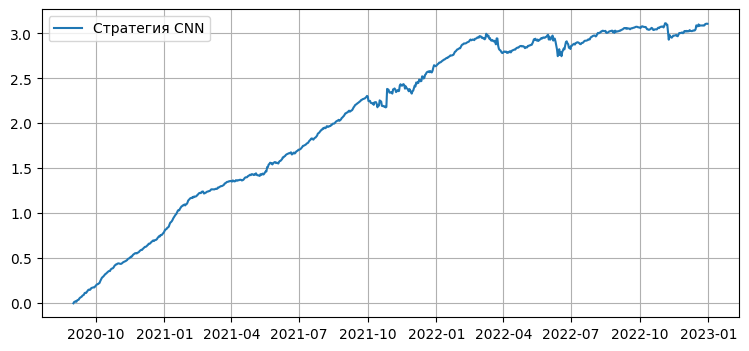

In [173]:
#CNN_WEIGHTS = pd.read_parquet("raw_alpha_weights/CNN_WEIGHTS.gzip")
close_df = pd.read_parquet("binance/close.parquet")["2020-09-01":].drop(BLOCK_TICKERS, axis=1)
vwap_df = pd.read_parquet("binance/vwap.parquet")["2020-09-01":].drop(BLOCK_TICKERS, axis=1)

CNN_ALPHA = Alpha(CNN_WEIGHTS, close_df, vwap_df)
CNN_ALPHA.truncate_and_normalize(0.05)
CNN_ALPHA.decay(7)

plt.figure(figsize=(9, 4))
CNN_ALPHA.backtest(display=True, label="Стратегия CNN")
plt.legend()
plt.grid()
plt.show()